# Benchmarking
benchmarking using [MQTBench](https://mqt.readthedocs.io/projects/bench/en/latest/Quickstart.html) with QFT for 15 qubits

In [2]:
from lib.distributed_coupling_map import build_coupling_list_ring, build_coupling_list_full, build_coupling_list_grid, build_coupling_list_line, build_coupling_list_t_horizontal, build_coupling_list_t_vertical
from lib.interaction_mapping import InteractionMapping
from lib.interaction_layout import InteractionLayout
from lib.lookahead_routing import DynamicLookaheadSwap
from lib.timer_helper import Timer

In [4]:
from qiskit.transpiler import CouplingMap, PassManager, StagedPassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_embed_passmanager, generate_routing_passmanager
from qiskit.providers import Backend
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_circuit_layout

In [5]:
from mqt.bench import get_benchmark, CompilerSettings, QiskitSettings

Set compiler level for MQTBench

In [6]:
optimization_level = 0
compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))

Circuit qftentangled[10] -> size: 292 depth: 83


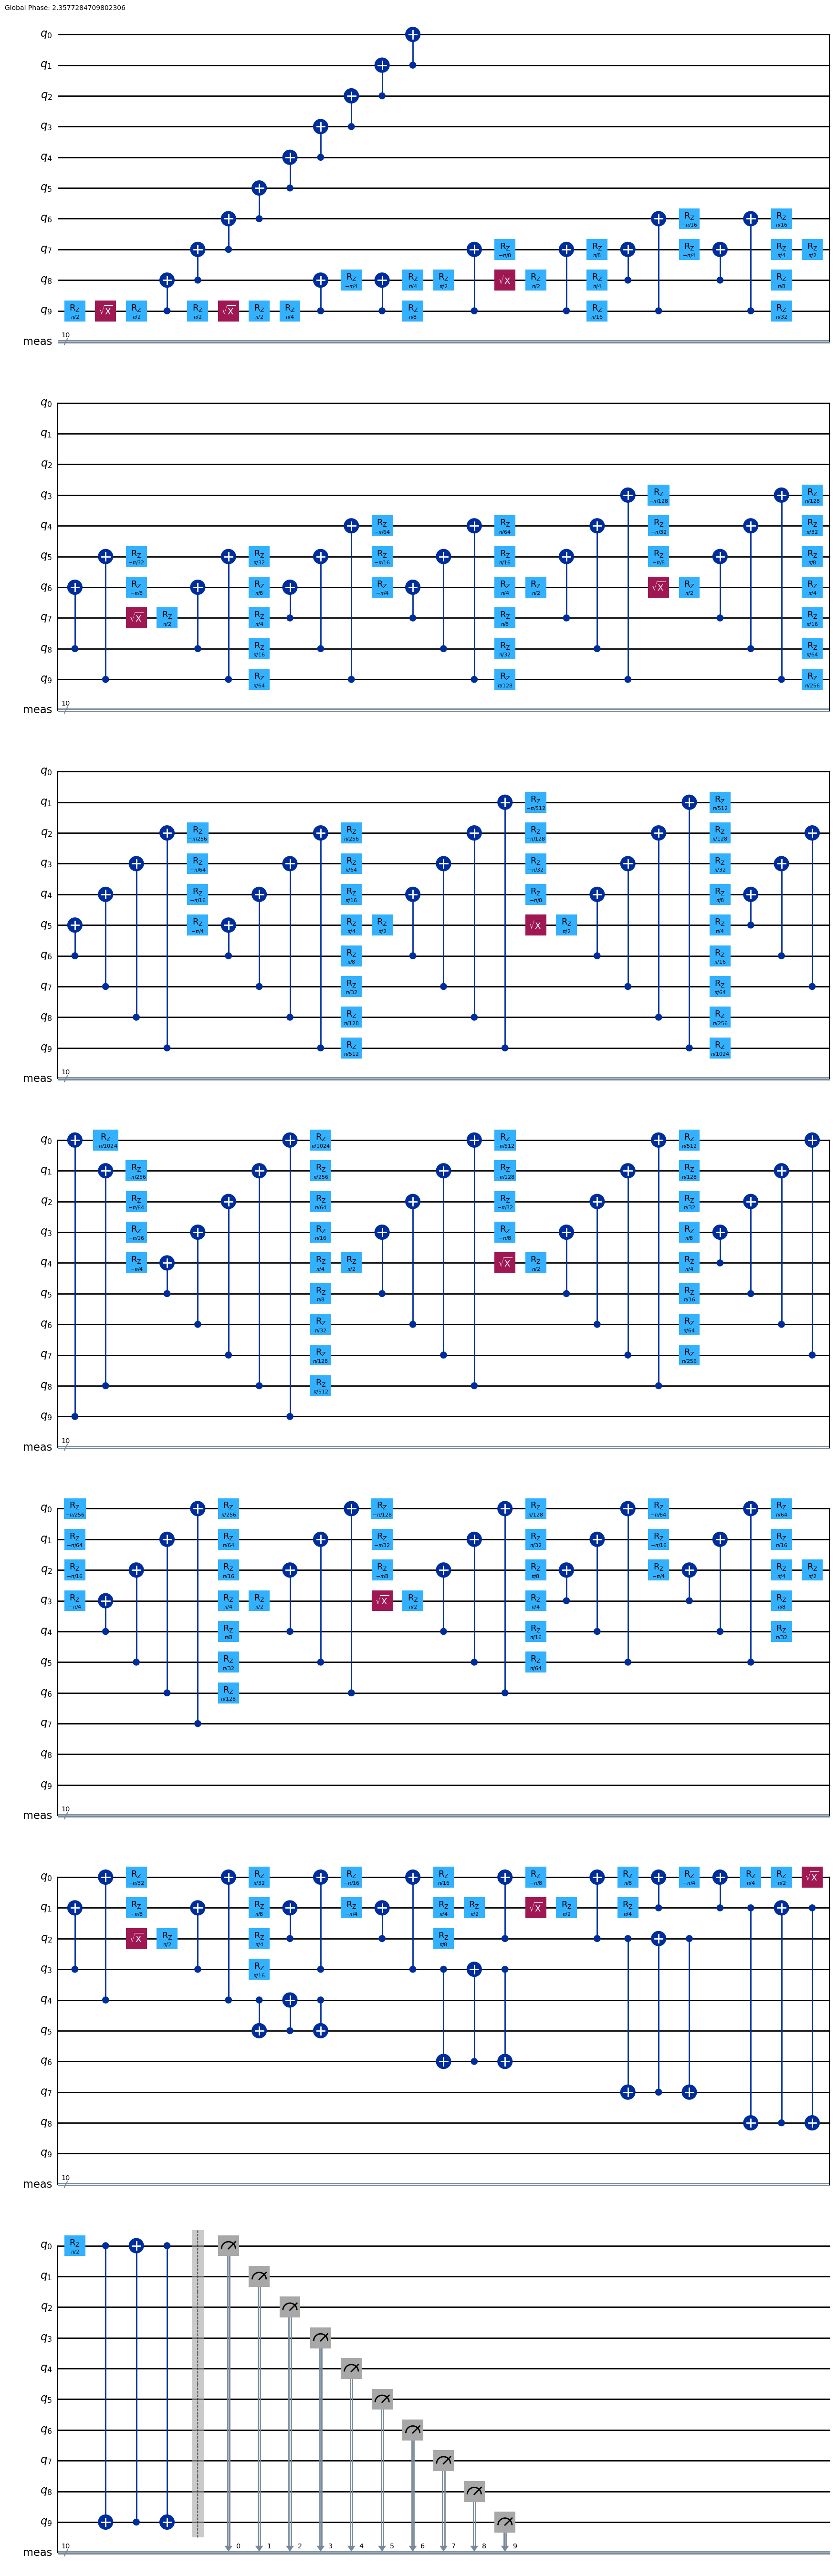

In [15]:
benchmark_name = "qftentangled"
level = "nativegates"
circuit_size = 10
qc_ghz = get_benchmark(
    benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
    compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
)
print(f"Circuit {benchmark_name}[{circuit_size}] -> size: {qc_ghz.size()} depth: {qc_ghz.depth()}")
display(qc_ghz.draw(output="mpl"))

Using `TrivialLayout` and `BasicSwap` routing  

#### TrivialLayout
Documentation: [`TrivialLayout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout)  
Choose a Layout by assigning n circuit qubits to device qubits 0, .., n-1.  
A pass for choosing a Layout of a circuit onto a Coupling graph, using a simple round-robin order.  
This pass associates a physical qubit (int) to each virtual qubit of the circuit (Qubit) in increasing order.  

#### BasicSwap
Documentation: [`BasicSwap`](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasicSwap)  
Map (with minimum effort) a DAGCircuit onto a coupling_map adding swap gates.  
The basic mapper is a minimum effort to insert swap gates to map the DAG onto a coupling map. When a cx is not in the coupling map possibilities, it inserts one or more swaps in front to make it compatible.  

Transpiled qftentangled[10] on TriviallLayout and BasicSwap routing -> size: 622 depth: 238


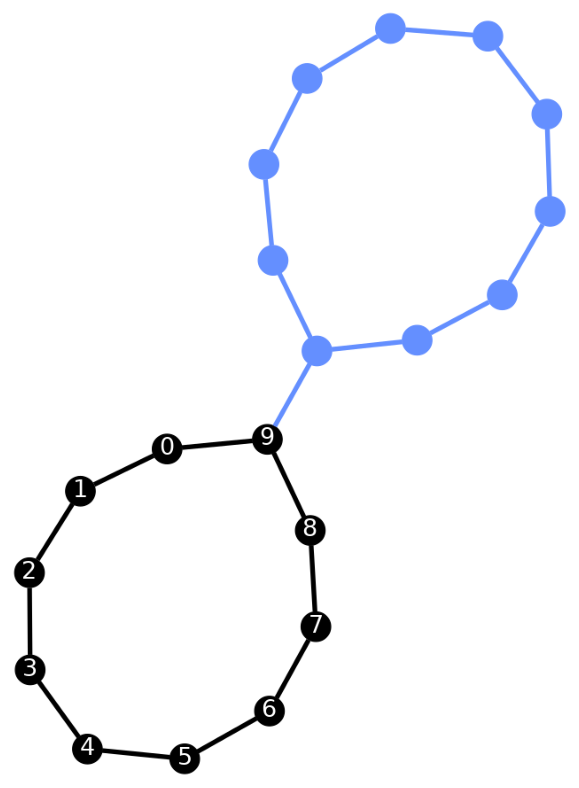

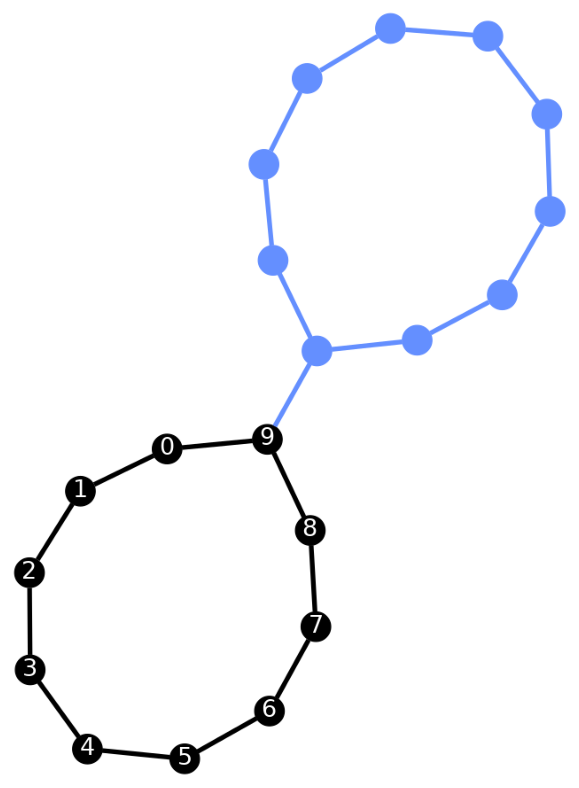

In [16]:
num_qubits = 10
num_group = 2
coupling_list_ring = build_coupling_list_ring(num_qubits, num_group)
coupling_map_ring = CouplingMap(couplinglist=coupling_list_ring)

backend_ring = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=coupling_map_ring)
basic_pass = generate_preset_pass_manager(optimization_level=0, backend=backend_ring, layout_method='trivial', routing_method='basic')
basic_ghz_isa = basic_pass.run(qc_ghz)
print(f"Transpiled {benchmark_name}[{circuit_size}] on TriviallLayout and BasicSwap routing -> size: {basic_ghz_isa.size()} depth: {basic_ghz_isa.depth()}")
display(plot_circuit_layout(basic_ghz_isa, backend_ring, view='physical'))
display(plot_circuit_layout(basic_ghz_isa, backend_ring, view='virtual'))

Using `SabreLayout` and `SabreSwap` routing  

#### SabreLayout
Documentation: [`SabreLayout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreLayout)  
Choose a Layout via iterative bidirectional routing of the input circuit.

Starting with a random initial Layout, the algorithm does a full routing of the circuit (via the routing_pass method) to end up with a final_layout. This final_layout is then used as the initial_layout for routing the reverse circuit. The algorithm iterates a number of times until it finds an initial_layout that reduces full routing cost.

#### SabreSwap
Documentation: [`SabreSwap`](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreSwap)  
Map input circuit onto a backend topology via insertion of SWAPs.

Implementation of the SWAP-based heuristic search from the SABRE qubit mapping paper [1] (Algorithm 1). The heuristic aims to minimize the number of lossy SWAPs inserted and the depth of the circuit.

This algorithm starts from an initial layout of virtual qubits onto physical qubits, and iterates over the circuit DAG until all gates are exhausted, inserting SWAPs along the way. It only considers 2-qubit gates as only those are germane for the mapping problem (it is assumed that 3+ qubit gates are already decomposed).

**References**:

[1] Li, Gushu, Yufei Ding, and Yuan Xie. “Tackling the qubit mapping problem for NISQ-era quantum devices.” ASPLOS 2019. [arXiv:1809.02573](https://arxiv.org/pdf/1809.02573.pdf)

Transpiled qftentangled[10] on SabreLayout and SabreSwap routing -> size: 442 depth: 223


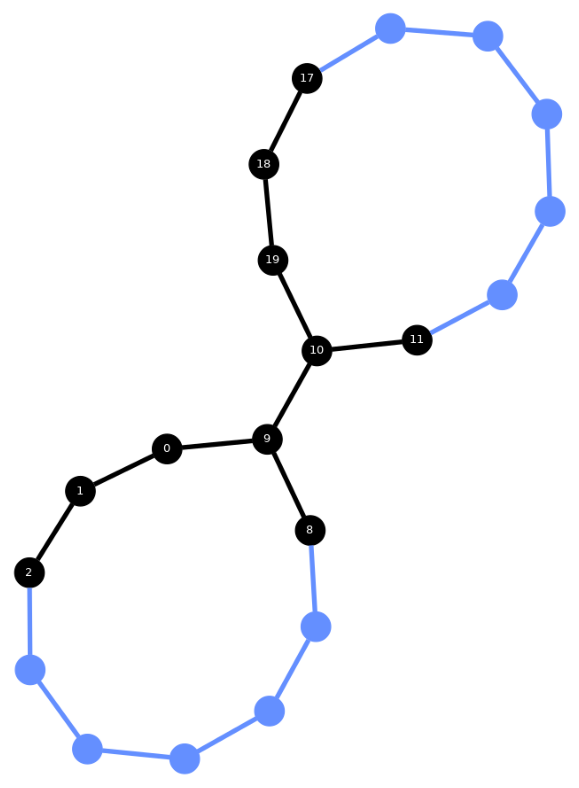

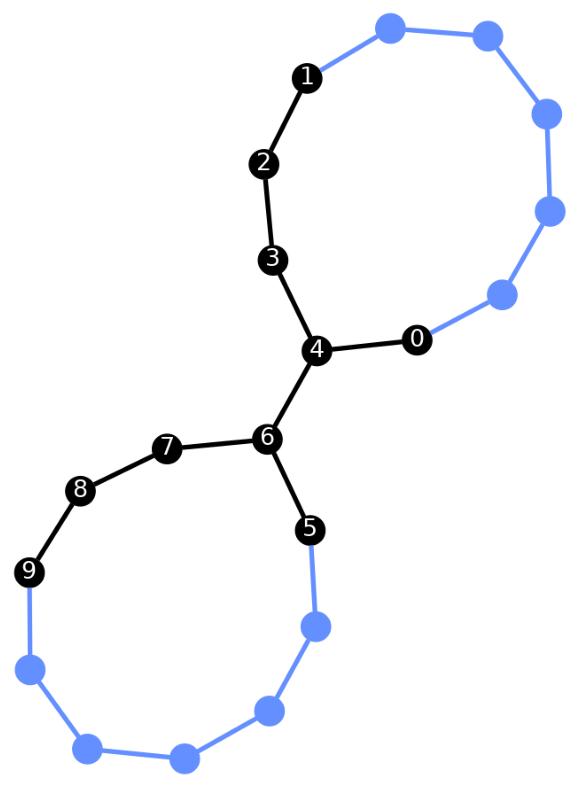

In [17]:
sabre_pass = generate_preset_pass_manager(optimization_level=0, backend=backend_ring, layout_method='sabre', routing_method='sabre')
sabre_ghz_isa = sabre_pass.run(qc_ghz)
print(f"Transpiled {benchmark_name}[{circuit_size}] on SabreLayout and SabreSwap routing -> size: {sabre_ghz_isa.size()} depth: {sabre_ghz_isa.depth()}")
display(plot_circuit_layout(sabre_ghz_isa, backend_ring, view='physical'))
display(plot_circuit_layout(sabre_ghz_isa, backend_ring, view='virtual'))

In [58]:
# use dictionary to save the result
benchmark_name_list = [
    # "ae", # list index out of range? because qreg use eval1, eval2, eval3
    "dj",
    # "grover-noancilla", # '[5] grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}
    # "grover-v-chain", # '[5] grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}
    "ghz",
    "graphstate",
    "portfolioqaoa",
    "portfoliovqe",
    "qaoa",
    "qft",
    "qftentangled",
    "qnn",
    # "qpeexact", # qreg use psi
    # "qpeinexact", # qreg use psi
    # "qwalk-noancilla", # '[5] qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}
    # "qwalk-v-chain", # '[5] qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}
    "random",
    "realamprandom",
    "su2random",
    "twolocalrandom",
    "vqe",
    "wstate",
    
    # non-scalable benchmarks
    
    # "shor", # benchmark_instance_name must be defined for this benchmark.
    # "pricingcall", # Benchmark pricingcall[5] -> size: 901 depth: 568 interval: 0.18169641494750977
    # "pricingput", # Benchmark pricingput[5] -> size: 931 depth: 568 interval: 0.1800365447998047
    # "groundstate", # benchmark_instance_name must be defined for this benchmark.
    # "routing",
    # "tsp",
]

# Initialize JSON

Initialize JSON structure tree

In [18]:
circuit_size_list = [5, 10, 15] # 20 cannot, runtime > 20mins for each algo

def init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark):
    for circuit_size in circuit_size_list:
        if str(circuit_size) not in dict_benchmark: # circuit size level
            dict_benchmark[str(circuit_size)] = {}
        for benchmark_name in benchmark_name_list:
            if benchmark_name not in dict_benchmark[str(circuit_size)]: # benchmark name level
                dict_benchmark[str(circuit_size)][benchmark_name] = {}
            if 'init' not in dict_benchmark[str(circuit_size)][benchmark_name]: # coupling map level
                dict_benchmark[str(circuit_size)][benchmark_name]['init'] = {}
    return dict_benchmark

Save dictionary JSON to file in folder `result/benchmarking_FINAL.json`

In [19]:
import json
def save_dict_to_file(dict_benchmark):
    with(open("result/benchmarking_FINAL.json", "w") as outfile):
        json.dump(dict_benchmark, outfile)

Initialize if empty file by declaring circuit size and layouts which are going to be used

In [59]:
# Initialize from EMPTY

# level: circuit_size -> benchmark_name -> coupling_map, ex: ['init'], ['ring_5_4'], ['line_5_4'] -> ['size'], ['swap'], ['depth' (optional)], ['interval']
# line, full, ring_10_2, ring_5_4, grid_3_3_2, grid_3_2_3, t_horizontal_4, t_vertical_4

# provide around 18 (grid) - 20 num_qubits in total
# dict_benchmark = {}
# dict_benchmark = init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark)
# print(dict_benchmark)
# save_dict_to_file(dict_benchmark)

Read from JSON file (if available)

In [20]:
import json
def open_json_from_file():
    with open("result/benchmarking_FINAL.json") as json_file:
        return json.load(json_file)

In [21]:
# Initialize from JSON

dict_benchmark = open_json_from_file()
print(dict_benchmark)

{'5': {'dj': {'init': {'size': 36, 'depth': 11, 'interval': 0.007391452789306641}, 'full_20_1': {'basic_size': 36, 'basic_depth': 11, 'basic_swap': 0, 'basic_interval': 0.00593256950378418, 'sabre_size': 36, 'sabre_depth': 11, 'sabre_swap': 0, 'sabre_interval': 0.009633779525756836, 'lookahead_size': 36, 'lookahead_depth': 11, 'lookahead_swap': 0, 'lookahead_interval': 0.0056610107421875}, 'line_20_1': {'basic_size': 72, 'basic_depth': 40, 'basic_swap': 36, 'basic_interval': 0.011270999908447266, 'sabre_size': 42, 'sabre_depth': 24, 'sabre_swap': 6, 'sabre_interval': 0.0072591304779052734, 'lookahead_size': 38, 'lookahead_depth': 14, 'lookahead_swap': 6, 'lookahead_interval': 0.006912708282470703}, 'full_10_2': {'basic_size': 36, 'basic_depth': 11, 'basic_swap': 0, 'basic_interval': 0.004221916198730469, 'sabre_size': 39, 'sabre_depth': 17, 'sabre_swap': 3, 'sabre_interval': 0.008487939834594727, 'lookahead_size': 36, 'lookahead_depth': 11, 'lookahead_swap': 0, 'lookahead_interval': 0.

In [22]:
def start_initial_benchmark(benchmark_name: str, circuit_size: int, dict_benchmark: dict):
    level = "nativegates"
    optimization_level = 0
    compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))
    with Timer() as t:
        qc = get_benchmark(
        benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
        compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
        )
        qc.remove_final_measurements()
    dict_benchmark[str(circuit_size)][benchmark_name]['init']['size'] = qc.size()
    dict_benchmark[str(circuit_size)][benchmark_name]['init']['depth'] = qc.depth()
    dict_benchmark[str(circuit_size)][benchmark_name]['init']['interval'] = t.interval

    dag = circuit_to_dag(qc)
    # TODO: remove measure because error in mapping physical wire -> logical qubit -> classical register
    return qc, dag

# if want to change interval in ms = t.interval*10**3

In [23]:
import math

def build_generic_backend(
    layout_name: str, num_qubits: int, num_group: int # num_rows and num_cols only used in grid
) ->  GenericBackendV2:
    if layout_name == "full":
        couplinglist = build_coupling_list_full(num_qubits, num_group)
        backend_qubits = num_qubits * num_group
    elif layout_name == "line":
        couplinglist = build_coupling_list_line(num_qubits, num_group)
        backend_qubits = num_qubits * num_group
    elif layout_name == "ring":
        couplinglist = build_coupling_list_ring(num_qubits, num_group)
        backend_qubits = num_qubits * num_group
    elif layout_name == "grid":
        num_rows = math.ceil(math.sqrt(num_qubits))
        num_columns = math.floor(math.sqrt(num_qubits))
        couplinglist = build_coupling_list_grid(num_rows, num_columns, num_group)
        backend_qubits = num_rows * num_columns * num_group
    elif layout_name == "t_horizontal":
        couplinglist = build_coupling_list_t_horizontal(num_group)
        backend_qubits = 5 * num_group
    elif layout_name == "t_vertical":
        couplinglist = build_coupling_list_t_vertical(num_group)
        backend_qubits = 5 * num_group
    else:
        raise Exception(f"Layout name: {layout_name} is not supported yet.")

    gen_backend = GenericBackendV2(num_qubits=backend_qubits, coupling_map=couplinglist) # can directly add coupling list without casting to CouplingMap
    return gen_backend

In [24]:
def build_pass_manager(
    routing_option: str, backend: Backend, best_layout=None
) -> PassManager:
    if routing_option == "lookahead":
        # if best_layout is None:
        #     raise Exception(
        #         f"Provide initial layout for Interaction Layout and Lookahead Swap."
        #     )
        pass_manager = StagedPassManager()
        pass_manager.layout = PassManager(InteractionLayout(
            coupling_map=backend.coupling_map, initial_map=best_layout
        ))
        pass_manager.layout += generate_embed_passmanager(backend.coupling_map)
        pass_manager.routing = generate_routing_passmanager(
            DynamicLookaheadSwap(backend.coupling_map), target=backend.coupling_map
        )

    elif routing_option == "sabre":
        pass_manager = generate_preset_pass_manager(
            optimization_level=0,
            backend=backend,
            layout_method="sabre",
            routing_method="sabre",
        )
    elif routing_option == "basic":
        pass_manager = generate_preset_pass_manager(
            optimization_level=0,
            backend=backend,
            layout_method="trivial",
            routing_method="basic",
        )
    else:
        raise Exception(f"Swap technique {routing_option} is not available yet.")
    return pass_manager

In [29]:
def update_dict_size_depth(qc, dag, layout_name, num_qubits, num_group, routing_option, dict_benchmark):
    with Timer() as lookahead:
        backend = build_generic_backend(layout_name, num_qubits, num_group)
        if layout_name == 'full':
            best_layout = [(idx, idx) for idx in range(dag.num_qubits())]
        else:
            mapping = InteractionMapping(backend.coupling_map, dag)
            best_layout = mapping.get_best_qpi_layout()
        print(f"Best layout: {best_layout}")
    
    with Timer() as t:
        pm = build_pass_manager(routing_option, backend, best_layout)
        isa = pm.run(qc)
        # display(plot_circuit_layout(isa, backend, view='virtual'))
        # display(plot_circuit_layout(isa, backend, view='physical'))
    
    if f'{layout_name}_{num_qubits}_{num_group}' not in dict_benchmark[str(circuit_size)][benchmark_name]:
        dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'] = {}
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_size'] = isa.size()
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_depth'] = isa.depth()
    

    if routing_option == 'lookahead':
        interval = lookahead.interval + t.interval
        additional_swap = (isa.size() - qc.size()) * 3 # TODO: add swap calculation here
    else:
        interval = t.interval
        additional_swap = (isa.size() - qc.size())
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_swap'] = additional_swap
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_interval'] = interval

In [26]:
benchmark_name_list = [
    # "ae", # qregs['q'] not found, found 'eval'
    "dj", # [5,10, 15] (3.9s)
    # "grover-noancilla", # 'qreg use AncillaQubit 'flag'
    # "grover-v-chain", # 'qreg use AncillaQubit 'flag'
    "ghz", # [5, 10, 15] DONE all3 (3.7s) [15] full_5_4 interaction timeout, 
    "graphstate", # [5, 10, 15] DONE all3 (4.5s)
    "portfolioqaoa", # [10] ring_7_3, ring_5_4 failed, [15] full_7_3, ring_7_3, ring_5_4 failed; full_5_4 interaction timeout
    "portfoliovqe", # [10] ring_7_3, ring_5_4 failed, [15] full_7_3, ring_7_3, ring_5_4 failed, full_5_4 interaction timeout
    "qaoa", # [5, 10, 15] (1m 35.7s)
    "qft", # [5, 10] [15] ring_7_3, ring_5_4 failed, full_5_4 interaction timeout
    "qftentangled", # [10] ring_7_3 failed, [15] ring_7_3, ring_5_4 failed, full_5_4 interaction timeout
    "qnn", # [10] ring_7_3, ring_5_4 failed, [15] full_7_3, ring_7_3, ring_5_4 failed; full_5_4 interaction timeout
    # "qpeexact", # qreg use psi Qubit(QuantumRegister(9, 'q'), 8), Qubit(QuantumRegister(1, 'psi'), 0)
    # "qpeinexact", # qreg use psi
    # "qwalk-noancilla", # '[5] qregs['q'] not found, found 'node', 'coin'
    # "qwalk-v-chain", # qregs['q'] not found, found 'ancilla', 'node', 'coin'
    "random", # [10] ring_7_3, ring_5_4 failed, [15] full_7_3, ring_7_3, ring_5_4 failed; full_5_4 interaction timeout
    "realamprandom", # [5] [10] ring_5_4 failed [15] full_7_3, ring_5_4 failed; full_5_4 interaction timeout
    "su2random", # [5] [10] ring_5_4 failed [15] full_7_3, ring_7_3, ring_5_4 failed; full_5_4 interaction timeout
    "twolocalrandom", # [5] [10] ring_5_4 faile [15] full_7_3, ring_5_4 failed; full_5_4 interaction timeout
    "vqe", # [5, 10] [15] ring_7_3, ring_5_4 failed; full_5_4 interaction timeout
    "wstate", # [5, 10, 15]; [15] full_5_4 interaction timeout
]

# Swap candidates failed for ring_5_4 probably it stops because at the very end, cannot go back? (removing assigned_swap, but still failed)

In [27]:
print(dict_benchmark)

{'5': {'dj': {'init': {'size': 36, 'depth': 11, 'interval': 0.007391452789306641}, 'full_20_1': {'basic_size': 36, 'basic_depth': 11, 'basic_swap': 0, 'basic_interval': 0.00593256950378418, 'sabre_size': 36, 'sabre_depth': 11, 'sabre_swap': 0, 'sabre_interval': 0.009633779525756836, 'lookahead_size': 36, 'lookahead_depth': 11, 'lookahead_swap': 0, 'lookahead_interval': 0.0056610107421875}, 'line_20_1': {'basic_size': 72, 'basic_depth': 40, 'basic_swap': 36, 'basic_interval': 0.011270999908447266, 'sabre_size': 42, 'sabre_depth': 24, 'sabre_swap': 6, 'sabre_interval': 0.0072591304779052734, 'lookahead_size': 38, 'lookahead_depth': 14, 'lookahead_swap': 6, 'lookahead_interval': 0.006912708282470703}, 'full_10_2': {'basic_size': 36, 'basic_depth': 11, 'basic_swap': 0, 'basic_interval': 0.004221916198730469, 'sabre_size': 39, 'sabre_depth': 17, 'sabre_swap': 3, 'sabre_interval': 0.008487939834594727, 'lookahead_size': 36, 'lookahead_depth': 11, 'lookahead_swap': 0, 'lookahead_interval': 0.

In [46]:
save_dict_to_file(dict_benchmark)
print(dict_benchmark[str(circuit_size)][benchmark_name])

{'init': {'size': 73, 'depth': 45, 'interval': 0.009667396545410156}, 'full_20_1': {'basic_size': 73, 'basic_depth': 45, 'basic_swap': 0, 'basic_interval': 0.005515575408935547, 'sabre_size': 73, 'sabre_depth': 45, 'sabre_swap': 0, 'sabre_interval': 0.008850812911987305, 'lookahead_size': 73, 'lookahead_depth': 45, 'lookahead_swap': 0, 'lookahead_interval': 0.005950927734375}, 'line_20_1': {'basic_size': 73, 'basic_depth': 45, 'basic_swap': 0, 'basic_interval': 0.0036962032318115234, 'sabre_size': 73, 'sabre_depth': 45, 'sabre_swap': 0, 'sabre_interval': 0.007516145706176758, 'lookahead_size': 78, 'lookahead_depth': 33, 'lookahead_swap': 15, 'lookahead_interval': 0.018105745315551758}, 'full_10_2': {'basic_size': 73, 'basic_depth': 45, 'basic_swap': 0, 'basic_interval': 0.00484919548034668, 'sabre_size': 73, 'sabre_depth': 45, 'sabre_swap': 0, 'sabre_interval': 0.009389400482177734, 'lookahead_size': 73, 'lookahead_depth': 45, 'lookahead_swap': 0, 'lookahead_interval': 0.00427699089050

In [48]:
# dict_benchmark = open_json_from_file(dict_benchmark)
interaction_timeout = ["twolocalrandom", "su2random", "realamprandom", "random", "qnn", "qftentangled", "portfolioqaoa", "portfoliovqe"]
circuit_size = 15 # circuit size [15], if [20] runtime >20mins
benchmark_name = "graphstate"
# for circuit_size in circuit_size_list:
for benchmark_name in benchmark_name_list:
    qc, dag = start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=circuit_size, dict_benchmark=dict_benchmark)
    routing_options = [
        'basic',
        'sabre', 
        'lookahead'
        ]

    distributed_options_failed = [
                                # ['ring', 7, 3], # failed at stopper 50
                                # ['full', 7, 3],
                                # ['ring', 5, 4], # failed with stopper swap at 50
                                # ['full', 5, 4],
                                # ['grid', 6, 4],
                                ]

    # number of qubits between 18 (grid) - 20 qubits
    distributed_options_final = [
        ['full', 20, 1], # monolithic
        ['line', 20, 1], # monolithic
        ['full', 10, 2], # distributed
        ['full', 7, 3],
        ['grid', 9, 2],
        ['grid', 8, 3],
        ['ring', 10, 2],
        ['ring', 7, 3],
        ['t_horizontal', 5, 4],
        ['t_vertical', 5, 4],
    ]

    for layout_name, num_qubits, num_group in distributed_options_final:
        for routing_option in routing_options:
            print(benchmark_name, layout_name, num_qubits, num_group, routing_option)
            try:
                update_dict_size_depth(qc, dag, layout_name, num_qubits, num_group, routing_option, dict_benchmark)
            except Exception as error:
                print("ERROR: ", error)
                continue

dj ring 5 4 basic
Best layout: [(14, 4), (0, 5), (1, 0), (2, 3), (3, 9), (4, 6), (5, 1), (6, 2), (7, 8), (8, 10), (9, 7), (10, 14), (11, 11), (12, 15), (13, 13)]
dj ring 5 4 sabre
Best layout: [(14, 4), (0, 5), (1, 0), (2, 3), (3, 9), (4, 6), (5, 1), (6, 2), (7, 8), (8, 10), (9, 7), (10, 14), (11, 11), (12, 15), (13, 13)]
dj ring 5 4 lookahead
Best layout: [(14, 4), (0, 5), (1, 0), (2, 3), (3, 9), (4, 6), (5, 1), (6, 2), (7, 8), (8, 10), (9, 7), (10, 14), (11, 11), (12, 15), (13, 13)]
dj full 5 4 basic
Best layout: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]
dj full 5 4 sabre
Best layout: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]
dj full 5 4 lookahead
Best layout: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]
dj grid 6 4 basic
Be

In [49]:
save_dict_to_file(dict_benchmark)
print(dict_benchmark[str(circuit_size)][benchmark_name])

{'init': {'size': 253, 'depth': 135, 'interval': 0.014425039291381836}, 'full_20_1': {'basic_size': 253, 'basic_depth': 135, 'basic_swap': 0, 'basic_interval': 0.01160430908203125, 'sabre_size': 253, 'sabre_depth': 135, 'sabre_swap': 0, 'sabre_interval': 0.013262510299682617, 'lookahead_size': 253, 'lookahead_depth': 135, 'lookahead_swap': 0, 'lookahead_interval': 0.008431673049926758}, 'line_20_1': {'basic_size': 253, 'basic_depth': 135, 'basic_swap': 0, 'basic_interval': 0.009413957595825195, 'sabre_size': 253, 'sabre_depth': 135, 'sabre_swap': 0, 'sabre_interval': 0.014319658279418945, 'lookahead_size': 267, 'lookahead_depth': 121, 'lookahead_swap': 42, 'lookahead_interval': 0.04821467399597168}, 'full_10_2': {'basic_size': 253, 'basic_depth': 135, 'basic_swap': 0, 'basic_interval': 0.0076885223388671875, 'sabre_size': 259, 'sabre_depth': 138, 'sabre_swap': 6, 'sabre_interval': 0.012930154800415039, 'lookahead_size': 253, 'lookahead_depth': 135, 'lookahead_swap': 0, 'lookahead_inter